# Image Denoising

**Name**: ZHU GUANGYU  
**Student ID**: 20165953  
**Github Repo**: [assignment11](https://github.com/z1ggy-o/cv_assignment/tree/master/assignment11)  

---

## Multi-objective least squares

In some applications we have *multiple* objectives, all of which we would like to be small:

$$J_{1} = ||A_{1}x-b_{1}||^{2}, \cdots, J_{k} = ||A_{k}x-b_{k}||^{2} $$

We seek a *single* $\hat{x}$ that gives a compromise, and makes them all small, tothe extent possible. We call this the *multi-objective*  least squares problem.

We cannot get a single $\hat{x}$ which makes all the objectives be minimum at same time, so we have to come out a compromise plan. A standard method for finding a value of $x$ that gives a compromise in making all the objectves small is to choose $x$ to minimize a *weighted sum objective*:

$$ J = \lambda_{1}J_{1} + \cdots + \lambda_{k}J_{k} = \lambda_{1}||A_{1}x-b_{1}||^{2} + \cdots + \lambda_{k}||A_{k}x-b_{k}||^{2}, $$

where $\lambda$ are positive *weights*, that express our relative desire for the terms to be small.

### Weighted sum least squares via stacking

We can minimize the weighted sum obejctive function by expressing it as a standard least squares problem, then we can solve it by the method we use before. Express $J$ as the norm squared of a single vector:

$$ J = \begin{Vmatrix}
\begin{bmatrix}
\sqrt{\lambda_{1}}(A_{1}x - b_{1}) \\
\vdots \\
\sqrt{\lambda_{k}}(A_{k}x - b_{k})
\end{bmatrix}
\end{Vmatrix}^{2}$$

so we have

$$
J = \begin{Vmatrix}
\begin{bmatrix}\sqrt{\lambda_{1}}A_{1}\\ \vdots \\ \sqrt{\lambda_{k}}A_{k} \end{bmatrix}x -
\begin{bmatrix}\sqrt{\lambda_{1}}b_{1}\\ \vdots \\ \sqrt{\lambda_{k}}b_{k} \end{bmatrix}
\end{Vmatrix}^{2}
=
\begin{Vmatrix}\tilde{A}x - \tilde{b} \end{Vmatrix}^{2}
$$

Now, we have reduced the problem of minimizing the weighted sum least squares objective to a standard lest squares problem.

Usually, we identify a *primary ojective* $J_{1}$ that we would like to be small. We also identify one or more *secondary objectives* that we would also like to be small. There are many possible sencondary objectives:

- $||x||^{2}$: $x$ should be small.
- $|| x - x^{prior}||^{2}$: $x$ should be near $x^{prior}$.
- $||Dx||^{2}$, where $D$ is the first difference matrix: $x$ should be smooth.

## Estination and inversion

In the broad application area of *estimation*, the goal is to estimate a set of $n$ values (also called parameters), the entries of the n-vector $x$. We are given a set of *m measurements*, the entries of an $m$-vector $y$. They are related by

$$ y = Ax + v $$

The $m$-vector $v$ is the *measurement noise*, and is unknown but presumed to be small. The estimation problem is to make a sensible guess as to what $x$ is, given $y$ and prior knowledge about $x$.

Of course we cannot expect to find $x$ exactly when the measurement noise is nonzero. This is called *approximate inversion*.

If we guess that $x$ has the value $\hat{x}$, then we are implicitly making the guess that $v$ has the value $y - A\hat{x}$. If we assume that $v$ is small, then a sensible choive for $\hat{x}$ is the least squares approximate solution, which minimizes $||A\hat{x}-y||^{2}$. We will take this as our primary objective. And we choose secondary objectives by the informations we know about $x$.

## Image Denoising

Image de-nosing is one of the *Inversion* problem. The vector $x$ is an image, and the matrix $A$ gives noise, so $y = Ax + v $ is a noisy image. 

Our prior infromation about $x$ is that it is smooth; neighboring pixels values are not very different from each other. So we choose $||Dx||^2$ be our secondary objective.

Because image is 2D, we form an estimate $\hat{x}$ image by minimizing a cost function of the form

$$||Ax - y||^2 + \lambda (||D_{h}x||^{2} + ||D_{v}x||^{2}) $$

Here $D_{v}$ and $D_{h}$ are vertical and horizontal differencing operations.

### Our specific denosing problem

In our problem, we do not use matrix $A$ to add noisy on image, but just given noisy image $y$, so our function is

$$ ||x - y||^2 + \lambda (||D_{h}x||^{2} + ||D_{v}x||^{2}) $$

Express it as a norm squared form, we have

$$
\begin{Vmatrix}
\begin{bmatrix} I \\ \sqrt{\lambda}D_{h}\\ \sqrt{\lambda}D_{v} \end{bmatrix}x -
\begin{bmatrix} y \\ 0 \\ 0 \end{bmatrix}
\end{Vmatrix}^{2}
=
\begin{Vmatrix}\tilde{A}x - \tilde{b} \end{Vmatrix}^{2}
$$

Suppose the vector $x$ has length $MN$ then $D_{h}$ is a $M(N-1) \times MN$ matrix, $D_{v}$ be the $(M-1)N \times MN$ matrix, and $I$ is a $M \times N$ identity matrix.

Now we can use standard least mean square method to get our $\hat{x}$.


---

## Implementation

### Import packages & read input data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import signal
from skimage import io, color
from skimage import exposure

file_image	= 'cau-resized.jpg'

im_color 	= io.imread(file_image)
im_gray  	= color.rgb2gray(im_color)
im          = (im_gray - np.mean(im_gray)) / np.std(im_gray)
row, col    = im.shape

### Function for generate noisy image

Here we add some noise on original image by normal distribution with mean 0 and standard deviation $\sigma$.

In [38]:
def create_noisy_img(img, noise_std):
    """Add noise on image
    
    Arguments:
        img(np.matrix): input clear image.
        noise_std: noise standard deviation.
    Return:
        noisy image
    """
    
    row, col = im.shape

    noise = np.random.normal(0, noise_std, (row, col))
    im_noise = im + noise
    
    return im_noise

### Build cost function

As we talked above, to build cost function, we need a $M \times N$ identity matrix $I$, a $M(N-1) \times MN$ matrix $D_{h}$, and a $(M-1)N \times MN$ matrix $D_{v}$ then combine them to a big matrix $\tilde{A}$.

In [3]:
def create_tilde_matrix(row, col, weight):
    """Build tilde matrix A in cost function
    
    Arguments:
        row: #row of image
        col: #column of image
        weight: weight of secondary objective
    Return:
        matrix row: row*(col-1) + (row-1)*col + row*col
               column: row * col
    """
    
    I = np.identity(row*col)
    Dx_weight = deri_h(row, col, weight)
    Dy_weight = deri_v(row, col, weight)
    
    A = np.vstack((I, Dx_weight, Dy_weight))
    
    return A


def deri_h(row, col, weight=1):
    dh = np.zeros((row*(col-1), row*col))
    
    for i in range(row*(col-1)):
        dh[i][i] = -1
        dh[i][i+row] = 1
        
    dh = math.sqrt(weight) * dh
    
    return dh


def deri_v(row, col, weight=1):
    m = np.zeros((row-1, row))
    for i in range(row-1):
        m[i][i] = -1
        m[i][i+1] = 1
    
    ident = np.identity(col)
    
    dv = np.kron(ident, m)
    dv = math.sqrt(weight) * dv
    
    return dv

#### Generate $\tilde{b}$

In [5]:
def create_tilde_b(row, col, img):
    length = (row-1)*col + row*(col-1) + row*col
    
    b = np.zeros(length)
    img_vec = []
    
    for i in range(col):
        column = img[:, i]
        for j in range(row):
            img_vec.append(column[j])
        
    for k in range(row*col):
        b[k] = img_vec[k]
    
    return b

#### Compute $\hat{x}$

In [39]:
def compute_param(A, y):
    return np.linalg.lstsq(A, y, rcond=None)[0]

### De-noising image

Since we have got all the components of the cost function, now we can compute the approximate inversion $\hat{x}$

In [102]:
def denoising(row, col, weight, img_noisy):
    """de-noising image
    
    Arguments:
        row: #row of image
        col: #col of image
        weight: weight for secondary objective
        img_noisy: noisy image
    Return:
        img_recon: de-noised image
        error: error of this denoising
    """
    # tranform image to vector
    b = create_tilde_b(row, col, im_noise)

    # generate matrix A
    matrix_A = create_tilde_matrix(row, col, weight)

    # compute recon image
    img_recon = compute_param(matrix_A, b)
    
    # compute error
    b_clear = create_tilde_b(row, col, im)
    cost_func = np.inner(matrix_A, img_recon) - b_clear
    error = np.linalg.norm(cost_func)**2
    
    # transform to matrix shape
    img_recon = (img_recon.reshape((col, row))).T
    
    
    return img_recon, error

---

## De-noising Images

Now, let's try our `denoising` function to do some image de-noising.

### Try different standard deviation $\sigma$ and regularization parameter $\lambda$

First create a function to convenient plotting.

In [54]:
def plot_images(img, img_noisy, img_recon):
    noise_recon = img_noisy - img_recon

    p1 = plt.subplot(2,2,1)
    p1.set_title('original image')
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    p2 = plt.subplot(2,2,2)
    p2.set_title('noisy image')
    plt.imshow(img_noisy, cmap='gray')
    plt.axis('off')

    p3 = plt.subplot(2,2,3)
    p3.set_title('reconstruction')
    plt.imshow(img_recon, cmap='gray')
    plt.axis('off')

    p4 = plt.subplot(2,2,4)
    p4.set_title('estimated noise')
    plt.imshow(noise_recon, cmap='gray')
    plt.axis('off')

    plt.show()

1. Try $\sigma = 0.2$, $\lambda = 0.25$

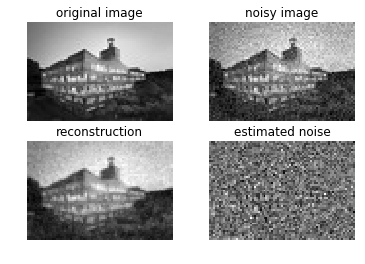

In [56]:
noise_std = 0.2
weight = 0.25

# generate noisy image
img_noisy = create_noisy_img(im, noise_std)

# denoising
img_recon, error = denoising(row, col, weight, img_noisy)

plot_images(im, img_noisy, img_recon)

2. Try $\sigma = 0.5$, $\lambda = 0.25$

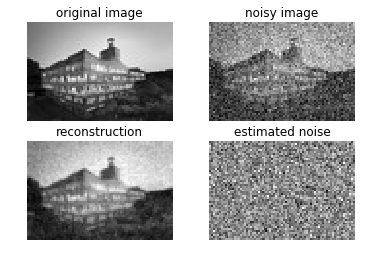

In [57]:
noise_std = 0.5
weight = 0.25

img_noisy = create_noisy_img(im, noise_std)
img_recon, error = denoising(row, col, weight, img_noisy)

plot_images(im, img_noisy, img_recon)

3. Try $\sigma = 0.2$, $\lambda = 1$

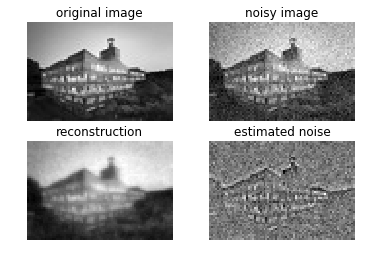

In [58]:
noise_std = 0.2
weight = 1

img_noisy = create_noisy_img(im, noise_std)
img_recon, error = denoising(row, col, weight, img_noisy)

plot_images(im, img_noisy, img_recon)

4. Try $\sigma = 0.5$, $\lambda = 1$

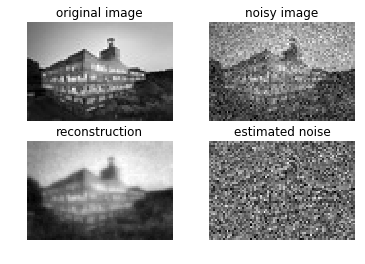

In [59]:
noise_std = 0.5
weight = 1

img_noisy = create_noisy_img(im, noise_std)
img_recon, error = denoising(row, col, weight, img_noisy)

plot_images(im, img_noisy, img_recon)

Since I do not get memory to compute bigger image, these may not very clear.

But we still can see from the above images, when $\sigma$ bigger the noise is more, when $\lambda$ get bigger the recon images are becoming smoother.

### See how $\lambda$ affects result

Let's fix $\sigma$ and try different $\lambda s$ to see the result. 

In [103]:
lambdas = [0.5**x for x in range(-5, 11)]
img_noisy = create_noisy_img(im, 0.5)

error_histo = []
imgs = []

for weight in lambdas:
    img_recon, error =denoising(row, col, weight, img_noisy)
    imgs.append(img_recon)
    error_histo.append(error)

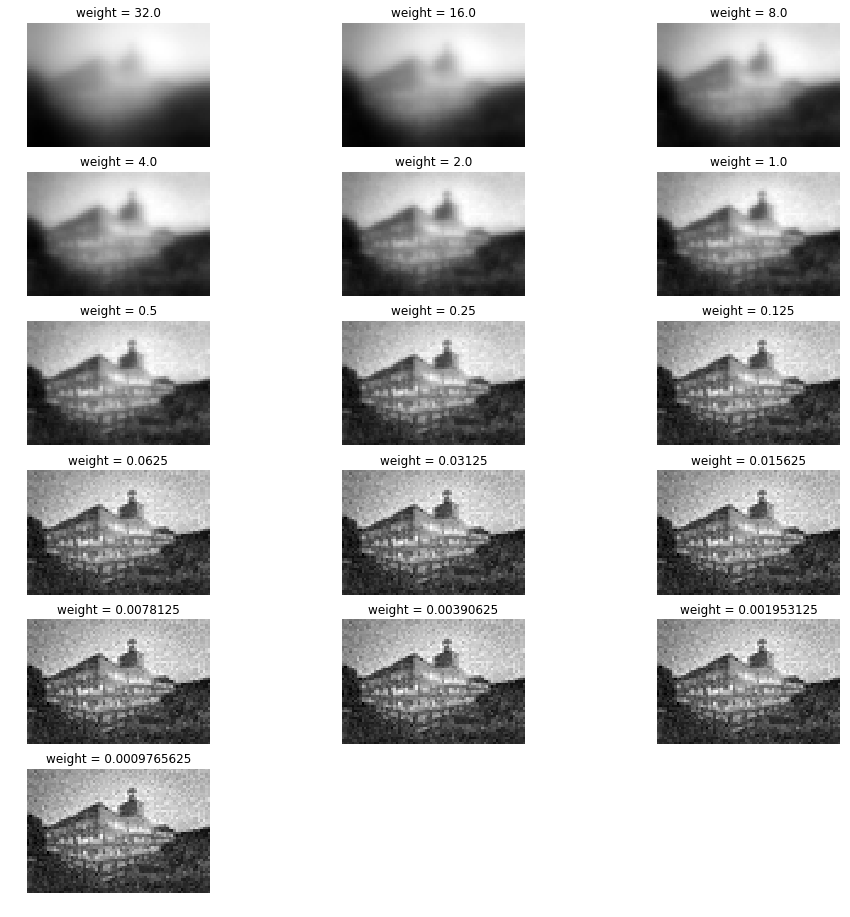

In [104]:
plt.figure(figsize=(16, 16))
for i in range(len(error_histo)):  
    p = plt.subplot(6,3,i+1)
    img_recon= imgs[i]
    p.set_title('weight = {}'.format(lambdas[i]))
    plt.imshow(img_recon, cmap='gray')
    plt.axis('off')
    
plt.show()

Let's see how the error of of reconstruction changes.

Error function is $E(u) = ||u-f||_{2}^{2} + \lambda||\nabla u||_{2}^{2}$

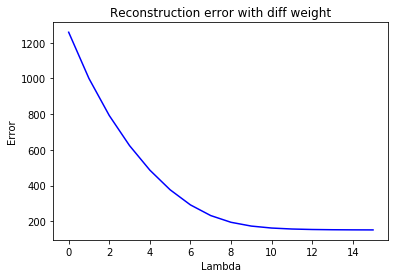

In [106]:
l = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

plt.title("Reconstruction error with diff weight")
plt.plot(error_histo, 'b-')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.show()

When $\lambda$ becomes bigger, reconstructed images are more smooth, so the error between it with input noisy image also get bigger.